<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/D_MSDS458_Assignment_03_EDA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## Experiments D: 1D CNN

## Functions and Packages

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.corpus import stopwords

from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.layers.core import Activation

In [2]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, epochs=200):
  timestamp=int(time.time())
  
  # Compile
  model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[    
        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
        ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        ]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x_train, y_train)

  print('Evaluating model performance with validation set')
  model.evaluate(x_valid, y_valid)

  return history, model

In [3]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [4]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Verify TensorFlow version and Keras version

In [6]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [7]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


### Stopword Function

In [8]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

## Mount Google Drive to Colab Environment

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Load **Data**

In [10]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

W1106 14:49:08.911803 140672917723008 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
2022-11-06 14:49:09.116653: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
INFO[dataset_info.py]: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
INFO[dataset_info.py]: Load dataset info from /tmp/tmp4en3warbtfds
INFO[dataset_info.py]: Field info.splits from disk and from code do not match. Keeping the one from code.
INFO[dataset_info.py]: Field info.supervised_keys from disk and from code do not match. Keepin

## Preparing Integer Sequence Datasets

In [11]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Experiment D: 1D CNN

Source: Deeap Learning with Python (Challot): Chapter 11

In [17]:
## Transformer encoder implimented as a subclass Layer

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
  
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [27]:
## Implementing positional embedding as sa subclassed layer

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
  
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
 
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### Model 1

In [61]:
## Using Transformer encoder for text classification 
vocab_size = 20000 
embed_dim = 256 
num_heads = 2 
dense_dim = 32 
  
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model1 = keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 256)         5120000   
                                                                 
 transformer_encoder_9 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 257 

In [62]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder1.keras",
                                    save_best_only=True)]

In [63]:
history1 = model1.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model1 = keras.models.load_model(
    "full_transformer_encoder1.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding}) 
print(f"Test acc: {model1.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
3563/3563 [==============================] - 27s 7ms/step - loss: -2544.2205 - accuracy: 0.3727 - val_loss: -7116.4858 - val_accuracy: 0.4163
Epoch 2/20
3563/3563 [==============================] - 25s 7ms/step - loss: -15668.5361 - accuracy: 0.3951 - val_loss: -26357.5234 - val_accuracy: 0.4167
Epoch 3/20
3563/3563 [==============================] - 25s 7ms/step - loss: -41207.5469 - accuracy: 0.3959 - val_loss: -58051.0312 - val_accuracy: 0.4095
Epoch 4/20
3563/3563 [==============================] - 25s 7ms/step - loss: -79300.8359 - accuracy: 0.3939 - val_loss: -102933.2266 - val_accuracy: 0.4193
Epoch 5/20
3563/3563 [==============================] - 25s 7ms/step - loss: -129993.2422 - accuracy: 0.3848 - val_loss: -158354.0156 - val_accuracy: 0.4192
Epoch 6/20
3563/3563 [==============================] - 25s 7ms/step - loss: -193174.9844 - accuracy: 0.3791 - val_loss: -226812.5156 - val_accuracy: 0.4017
Epoch 7/20
3563/3563 [==============================] - 25s 7ms/ste

In [64]:
## Metrics
history_dict = history1.history
history_dict.keys()

losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

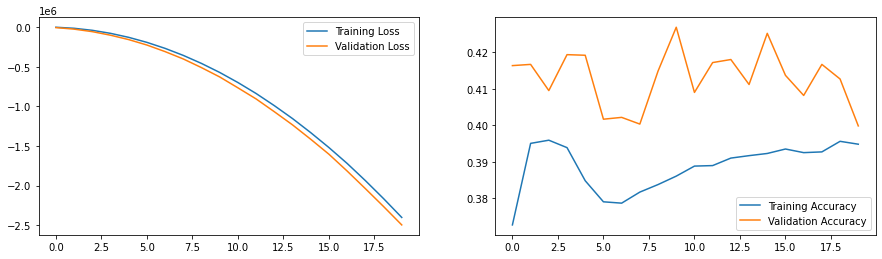

In [65]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Model 2

In [56]:
## Using Transformer encoder for text classification 
vocab_size = 10000 
embed_dim = 256 
num_heads = 2 
dense_dim = 32 
  
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)
model2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 256)         2560000   
                                                                 
 transformer_encoder_8 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 257 

In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder2.keras",
                                    save_best_only=True)]

In [58]:
history2 = model2.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model2 = keras.models.load_model(
    "full_transformer_encoder2.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding}) 
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
3563/3563 [==============================] - 27s 7ms/step - loss: -2636.0156 - accuracy: 0.3708 - val_loss: -7358.6694 - val_accuracy: 0.4168
Epoch 2/20
3563/3563 [==============================] - 25s 7ms/step - loss: -16488.4707 - accuracy: 0.3895 - val_loss: -27728.7949 - val_accuracy: 0.4003
Epoch 3/20
3563/3563 [==============================] - 25s 7ms/step - loss: -43771.2031 - accuracy: 0.3740 - val_loss: -61470.5234 - val_accuracy: 0.3983
Epoch 4/20
3563/3563 [==============================] - 25s 7ms/step - loss: -84415.8281 - accuracy: 0.3765 - val_loss: -107745.1641 - val_accuracy: 0.3912
Epoch 5/20
3563/3563 [==============================] - 25s 7ms/step - loss: -138401.3281 - accuracy: 0.3776 - val_loss: -168514.3125 - val_accuracy: 0.4088
Epoch 6/20
3563/3563 [==============================] - 25s 7ms/step - loss: -205356.8281 - accuracy: 0.3816 - val_loss: -241769.4531 - val_accuracy: 0.3955
Epoch 7/20
3563/3563 [==============================] - 25s 7ms/ste

In [59]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

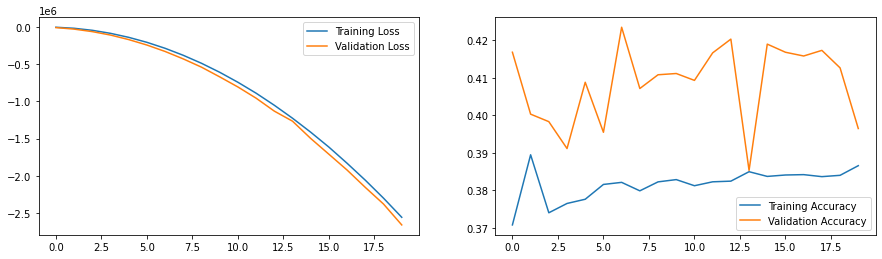

In [60]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Model 3

In [49]:
## Using Transformer encoder for text classification 
vocab_size = 20000 
embed_dim = 550 
num_heads = 2 
dense_dim = 32 
  
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model3 = keras.Model(inputs, outputs)
model3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 550)         11000000  
                                                                 
 transformer_encoder_7 (Tran  (None, None, 550)        2461832   
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_7 (Glo  (None, 550)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 550)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 551 

In [50]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder3.keras",
                                    save_best_only=True)]

In [51]:
history3 = model3.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model3 = keras.models.load_model(
    "full_transformer_encoder3.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding}) 
print(f"Test acc: {model3.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
3563/3563 [==============================] - 36s 10ms/step - loss: -5305.5073 - accuracy: 0.3453 - val_loss: -14596.4229 - val_accuracy: 0.3897
Epoch 2/20
3563/3563 [==============================] - 34s 10ms/step - loss: -32964.2266 - accuracy: 0.3763 - val_loss: -55588.4336 - val_accuracy: 0.3957
Epoch 3/20
3563/3563 [==============================] - 34s 10ms/step - loss: -88322.2891 - accuracy: 0.3914 - val_loss: -124321.3438 - val_accuracy: 0.4027
Epoch 4/20
3563/3563 [==============================] - 35s 10ms/step - loss: -171224.1250 - accuracy: 0.3924 - val_loss: -220396.1406 - val_accuracy: 0.4142
Epoch 5/20
3563/3563 [==============================] - 35s 10ms/step - loss: -281623.5625 - accuracy: 0.3912 - val_loss: -343823.3750 - val_accuracy: 0.4067
Epoch 6/20
3563/3563 [==============================] - 34s 10ms/step - loss: -419239.0625 - accuracy: 0.3916 - val_loss: -494390.1562 - val_accuracy: 0.4085
Epoch 7/20
3563/3563 [==============================] - 35

In [54]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

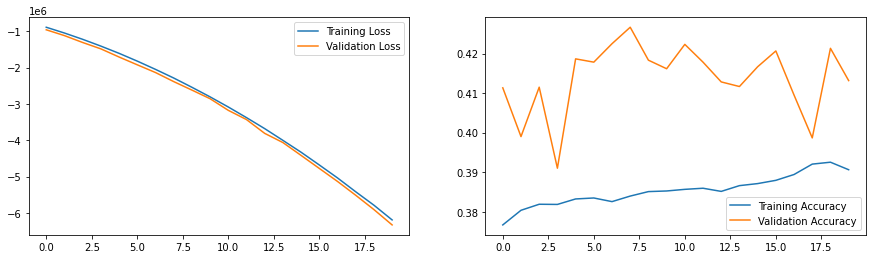

In [55]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()